In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from scipy import stats  # 과학용 계산 라이브러리

In [2]:

# 데이터 로드 및 전처리
data = pd.read_csv('abalone.csv')
data = pd.get_dummies(data, columns=['Sex'], drop_first=True)

data

,id,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_I,Sex_M
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,False,True
1,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,False,True
2,2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,False,False
3,3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,False,True
4,4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,True,False
...,...,...,...,...,...,...,...,...,...,...,...
4172,4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,False,False
4173,4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,False,True
4174,4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,False,True
4175,4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,False,False


In [3]:
# 컬렴명 확인
data.columns

Index(['id', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
       'Viscera_weight', 'Shell_weight', 'Rings', 'Sex_I', 'Sex_M'],
      dtype='object')

Text(0.5, 1.0, 'check the label')

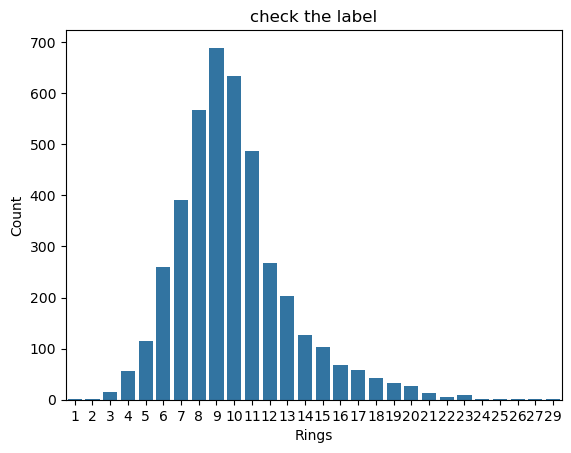

In [4]:
# 레이블 갯수 확인 (그래프)
sns.countplot(data = data, x="Rings") #df 데이터프레임에서 Rings 열의 값을 기준으로 각 레이블의 빈도수를 계산해 막대 그래프를 생성
plt.xlabel("Rings") 
plt.ylabel("Count")
plt.title("check the label") #그래프의 제목을 설정

In [5]:
# 결측치 제거
data = data.dropna()
data.isnull().sum()

id                0
Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
Sex_I             0
Sex_M             0
dtype: int64

In [6]:
#전복 데이터는 원래 시계열 데이터는 아니지만, 특정 연속적인 패턴을 분석하기 위해 시계열 형식으로 변환
#시계열 데이터를 분할하기 위해 split_sequences를 사용

In [7]:
from collections import Counter
import numpy as np

def split_sequence(sequences, n_steps):
    X, y = list(), list()  # 빈 리스트를 생성하여 시퀀스 데이터와 레이블을 담을 공간을 만듦
    for i in range(len(sequences)):  # 전체 시퀀스 데이터를 순회
        # find the end of this pattern
        end_ix = i + n_steps  # 현재 인덱스(i)에서 n_steps만큼 떨어진 시퀀스의 끝을 계산
        # check if we are beyond the dataset
        if end_ix > len(sequences):  # 시퀀스 끝이 데이터의 범위를 넘어서는지 확인
            break  # 범위를 넘으면 루프 종료
        # gather input (X) and output parts (y)
        seq_x = sequences[i:end_ix, :-1]  # 입력 데이터 (특징 데이터)
        seq_y_values = sequences[i:end_ix, -1]  # 시퀀스 동안의 출력 데이터 (레이블들)
        
        # 가장 빈번하게 나온 레이블 찾기
        most_common_label = Counter(seq_y_values).most_common(1)[0][0]
        
        X.append(seq_x)  # 입력 데이터 추가
        y.append(most_common_label)  # 가장 많이 나온 레이블 추가
    
    return np.array(X), np.array(y)  # 리스트를 numpy 배열로 변환하여 반환

In [8]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# 특성과 레이블 설정
X = data.drop('Rings', axis=1).values
y = data['Rings'].values

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 시퀀스 길이 설정
n_steps = 3  # 예시로 3개의 시퀀스를 사용

# 시퀀스 데이터 분할
X_seq, y_seq = split_sequence(X_scaled, n_steps)

## CNN, LSTM 분류

In [9]:
# 회귀 문제에 맞게 훈련/테스트 데이터 분할
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# CNN + LSTM 모델 정의 (회귀용)
from tensorflow.keras import layers, models

model_reg = models.Sequential([
    layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, X_train.shape[2])),
    layers.MaxPooling1D(pool_size=2),
    layers.LSTM(50, activation='relu'),
    layers.Dense(1)  # 회귀 문제이므로 출력층은 1개
])

model_reg.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# 모델 학습
history_reg = model_reg.fit(X_train, y_train_reg, epochs=50, batch_size=32, validation_split=0.2)

# 모델 평가
loss_reg, mae_reg = model_reg.evaluate(X_test, y_test_reg)
print(f'평가 손실 (회귀): {loss_reg}, 평균 절대 오차: {mae_reg}')


Epoch 1/50


C:\Users\tyra\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.8729 - mae: 0.8565 - val_loss: 0.7827 - val_mae: 0.7820
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7330 - mae: 0.7308 - val_loss: 0.7741 - val_mae: 0.7654
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7223 - mae: 0.7206 - val_loss: 0.7562 - val_mae: 0.7434
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7156 - mae: 0.7055 - val_loss: 0.7524 - val_mae: 0.7353
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7077 - mae: 0.6940 - val_loss: 0.7464 - val_mae: 0.7235
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7081 - mae: 0.6961 - val_loss: 0.7449 - val_mae: 0.7179
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7137 - mae: 0.6954 - val_loss: 0.7434 - val_mae: 0.7180
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6914 - mae: 0.6841 - val_loss: 0.7481 - val_mae: 0.7208
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7081 - mae: 0.6952 - va

In [10]:
# 1주차 과제에서 그냥 DL을 한 것과는 다르게 회귀에서 유의미한 성과가 있었다. 손실이 많이 줄은 것 같다.

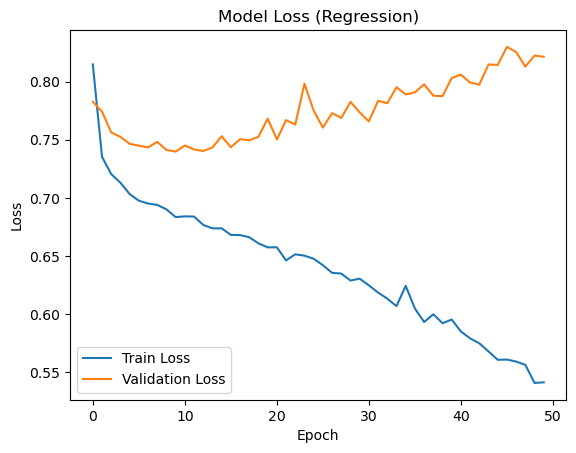

In [11]:
import matplotlib.pyplot as plt

# 회귀 학습 곡선 시각화
plt.plot(history_reg.history['loss'], label='Train Loss')
plt.plot(history_reg.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Regression)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()



# DL_분류

Epoch 1/20


C:\Users\tyra\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6013 - loss: 0.9041 - val_accuracy: 0.6358 - val_loss: 0.8001
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6313 - loss: 0.8001 - val_accuracy: 0.6518 - val_loss: 0.7788
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6486 - loss: 0.7632 - val_accuracy: 0.6486 - val_loss: 0.7933
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6545 - loss: 0.7706 - val_accuracy: 0.6837 - val_loss: 0.7588
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6793 - loss: 0.7227 - val_accuracy: 0.6581 - val_loss: 0.7834
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6764 - loss: 0.7255 - val_accuracy: 0.6805 - val_loss: 0.7604
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6743 - loss: 0.7348 - val_accuracy: 0.6709 - val_loss: 0.7671
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6724 - loss: 0.7146 - val_accuracy: 0.6741 - val_loss: 0.7711
Epo

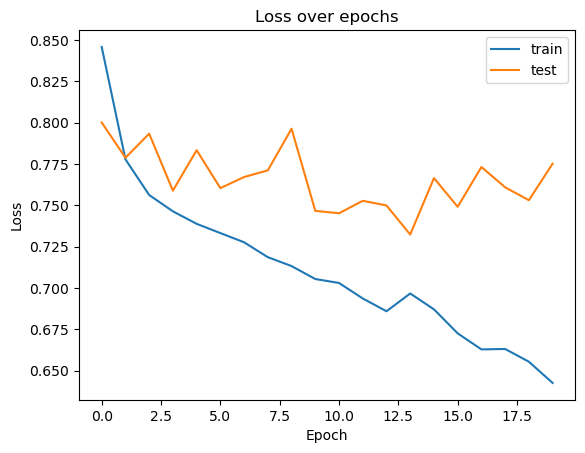

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6505 - loss: 0.7829 
테스트 손실: 0.7609362602233887, 테스트 정확도: 0.6605944633483887
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


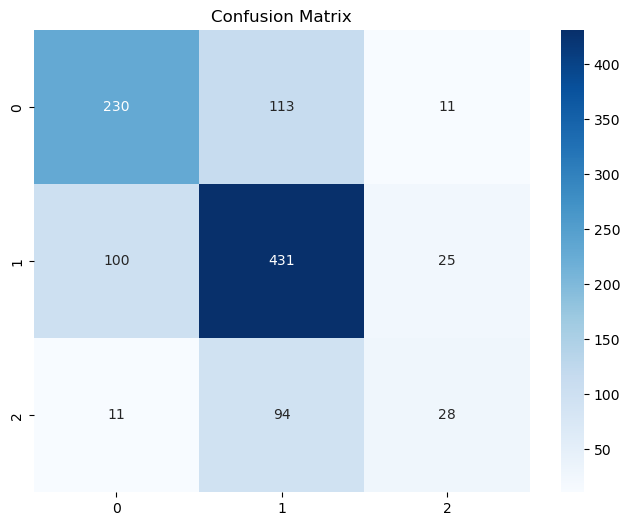

정확도: 0.660594439117929


In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from collections import Counter

# 데이터 로드 및 전처리
data = pd.read_csv('abalone.csv')
data = pd.get_dummies(data, columns=['Sex'], drop_first=True)

# X, y 설정
X = data.drop(['Rings'], axis=1).values
y = pd.cut(data['Rings'], bins=[0, 8, 12, np.inf], labels=[0, 1, 2]).values  # 범주형 변환

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 시퀀스 데이터를 분할하는 함수 정의
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x = sequences[i:end_ix, :-1]
        seq_y_values = sequences[i:end_ix, -1]
        most_common_label = Counter(seq_y_values).most_common(1)[0][0]
        X.append(seq_x)
        y.append(most_common_label)
    return np.array(X), np.array(y)

# y 데이터를 넘파이 배열로 변환 후 train과 test 세트를 결합
y_train_array = np.array(y_train)
train_set = np.c_[X_train, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]

# 시퀀스 길이 설정
n_steps = 3

# 시퀀스 데이터 분할
X_train_seq, y_train_seq = split_sequences(train_set, n_steps)
X_test_seq, y_test_seq = split_sequences(test_set, n_steps)

# 출력 변수를 범주형으로 변환
y_train_seq = to_categorical(y_train_seq)
y_test_seq = to_categorical(y_test_seq)

# CNN , LSTM 모델 정의
n_timesteps, n_features = X_train_seq.shape[1], X_train_seq.shape[2]
n_outputs = y_train_seq.shape[1]

model = Sequential()
model.add(LSTM(units=128, input_shape=(n_timesteps, n_features)))
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_split=0.1, shuffle=True)

# 학습 곡선 시각화
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# 테스트 데이터로 모델 평가
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f'테스트 손실: {loss}, 테스트 정확도: {accuracy}')

# 예측 결과 및 혼동 행렬
y_test_arg = np.argmax(y_test_seq, axis=1)
Y_pred = np.argmax(model.predict(X_test_seq), axis=1)

# 혼동 행렬 시각화
cm = confusion_matrix(y_test_arg, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# 분류 보고서 및 정확도 출력
print(f'정확도: {accuracy_score(y_test_arg, Y_pred)}')
